# Uncapacitated Facility Location Problem
## Setup

In [248]:
# import
from pulp import *
from solver_utils import *
from data_utils import *
import numpy as np

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-white')

# services
Data = DataGenerator()
Log = DataLogger()

## Primal Model

In [249]:
def build_primal(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(profits) - lpSum(fixed_costs)

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Relaxed Model

In [250]:
def build_relaxed(c_num, l_num, u_vector, C, F):
    """
    Lagrange relaxation for UFL problem as in Wolsey
    """

    # problem instance
    problem = LpProblem("UFL - Lagrange Relaxed Problem (Wolsey)", sense=LpMaximize)

    # check lagrange multipliers vector
    if len(u_vector) != c_num : 
        raise ValueError('Invalid u_vect size')

    # decision variables    
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    lagrange = [u_vector[i] * (1 - x[i][j]) for i in range(c_num) for j in range(l_num)]

    problem += lpSum(profits) - lpSum(fixed_costs) + lpSum(lagrange)

    # constraints
    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0

    return problem

## Subgradient Algorithm

In [251]:
def run_subgradient(c_num, l_num, u_vector, z_ip, C, F):
    # parameters
    t_max = c_num # maximum loops w/ improvement
    k = 1 # no improvement loop counter
    alpha_stop = 0.05 # stop parameter
    alpha = 2
    z_best = np.Infinity
    p_lr_best = None

    while True:
        # compute best z(u)
        p_lr = build_relaxed(c_num, l_num, u_vector, C, F)
        solve(p_lr)
        z_lr = get_objectiveFunction_value(p_lr)
        Log.logData('z_lr', z_lr)
        Log.logData('z_ip', z_ip) # simplify plotting

        # compute subgradient
        x_lr = get_variable_value(p_lr, 'x')
        # print(f"x_lr:\n {x_lr}")
        sg = subgradient_tbn(x_lr, c_num, l_num)
        # print(f"subgradient vector:\n {sg}")

        # check subgradient
        if not np.any(sg):
            print(f"null subgradient:\n {sg}")
            p_lr_best = p_lr
            break

        # compute step size            
        step = step_tbn(alpha, z_ip, z_lr, sg)
        
        # compute new lagrange multipliers
        u = u_vector #copy
        u_vector = update_lagrange_tbn(u, step, sg)

        # check bound
        if round(z_lr, 3) < round(z_best, 3):
            z_best = z_lr
            p_lr_best = p_lr
            k = 0
            print(f"z_best: {z_best}")
            
        # check counter
        if k == t_max:
            alpha = alpha / 2
            k = 0
            print(f"alpha: {alpha}")

        # check stop condition
        if alpha < alpha_stop:
            break
        
        k = k + 1
    return (z_best, p_lr_best)

### Compute subgradient vector

In [252]:
def subgradient_tbn(x_lr, c_num, l_num):
    # reshape X matrix
    x_lr = np.reshape(x_lr, (c_num, l_num)) 

    # compute D*x(u)
    d_x = [sum([x_lr[i][j] for j in range(l_num)]) for i in range(c_num)]
    # print(x_lr)
    # print(d_x)

    # d vector
    d = np.ones(c_num)

    # subgradient
    sg = d - d_x
    #print(f"subgradient: \n{sg}")

    return sg

### Compute step size

In [253]:
def step_tbn(alpha, z_ip, z_lr, subgradient):
    num = np.cbrt(np.abs(z_ip - z_lr))
    den = (np.linalg.norm(subgradient)) ** 2
    step = alpha * num / den
    
    # log data
    Log.logData('step_size', step)
    Log.logData('alpha', alpha)

    #print(f"step_tbn: {step}")
    return step

### Compute new Lagrange multipliers vector

In [254]:
def update_lagrange_tbn(u, step, subgradient):
    u_next = u + step * subgradient

    #print(f"u_next_tbn: \n{u_next}")
    return u_next

## Results
### Run

In [255]:
def runner(c_num=10, l_num=2):    
    # init c_num revenues
    C = Data.INT_matrix(c_num, l_num, False)

    # init facilities service cost
    f_avg_profit = np.average(C) # avg facility profit   
    f_min_cost = f_avg_profit
    f_max_cost = f_avg_profit * c_num * 2
    F = Data.INT_vector(l_num, f_min_cost, f_max_cost, False)
    # F = Data.INT_vector(l_num, False)
    
    # lagrange multipliers
    #u_vector = Data.INT_vector(c_num)
    u_vector = np.zeros(c_num)
    #u_vector = Data.INT_vector(c_num, f_min_cost, f_max_cost, False)

    
    #print(f"C:\n {C}")
    #print(f"F:\n {F}")
    
    # IP problem      
    ip_problem = build_primal(c_num, l_num, C, F)
    print("####################")
    print("SOLVE PRIMAL PROBLEM")
    
    solve(ip_problem, console_out=False)
    pY = get_variable_value(ip_problem, 'y')
    pX = get_variable_value(ip_problem, 'x').reshape(c_num, l_num)
    pZ = get_objectiveFunction_value(ip_problem)    
    print(f"pY = {pY}")
    #print(f"pX = \n {pX}")
    print(f"pZ = {pZ}")
    print("####################\n\n")
    
    
    
    # LR problem (tbn)
    print("####################")
    print("SOLVE RELAXED PROBLEM")    
    
    (rZ, rP) = run_subgradient(c_num, l_num, u_vector, pZ, C, F)
    rY = get_variable_value(rP, 'y')
    rX = get_variable_value(rP, 'x').reshape(c_num, l_num)
    print(f"rY = {rY}")
    #print(f"rX = \n {rX}")
    print(f"rZ = {rZ}")
    print("####################\n\n")

# Run command
runner(50, 10)

####################
SOLVE PRIMAL PROBLEM
pY = [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
pZ = 168.0
####################


####################
SOLVE RELAXED PROBLEM
z_best: 211.0
z_best: 196.9864077584519
z_best: 184.69906074068842
z_best: 174.47498622374053
z_best: 167.01955203516673
z_best: 163.0457931884655
z_best: 156.22683487671975
z_best: 147.12719085454
z_best: 136.11381927726984
z_best: 123.42968515138764
z_best: 109.2475411098302
z_best: 93.69736397834168
z_best: 79.23429682216354
z_best: 68.08223740605717
z_best: 57.38515770368974
z_best: 49.704628983226996
z_best: 41.850297379566705
z_best: 33.825845205083375
z_best: 25.634731800166374
z_best: 17.280215073546643
z_best: 8.76537024595647
z_best: 0.0931062460724783
z_best: -8.300364907607275
z_best: -13.90762976571006
z_best: -19.573721981099112
z_best: -25.298043234250343
z_best: -31.0800130377039
z_best: -36.91906786923886
z_best: -42.81466036289851
z_best: -48.76625855291954
z_best: -54.77334516621366
z_best: -59.890277973000806
z_b

### Plot results

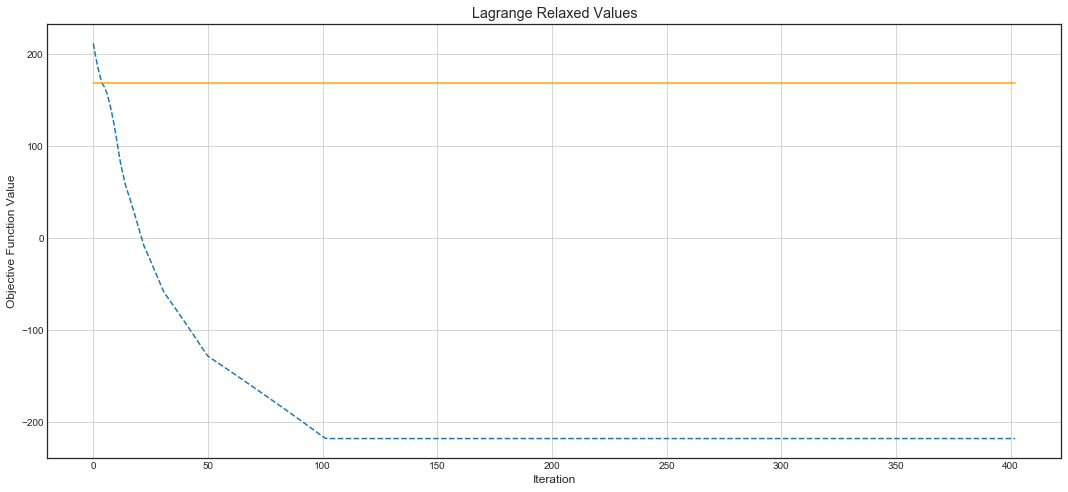

In [256]:
# subgradient bound improvement
def plot_subgradient():    
    fig = plt.figure()    
    z_subgradient = Log.d['z_lr']
    z_ip = Log.d["z_ip"]
    plt.plot(z_subgradient, linestyle='dashed')
    plt.plot(z_ip, color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Lagrange Relaxed Values')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_subgradient()

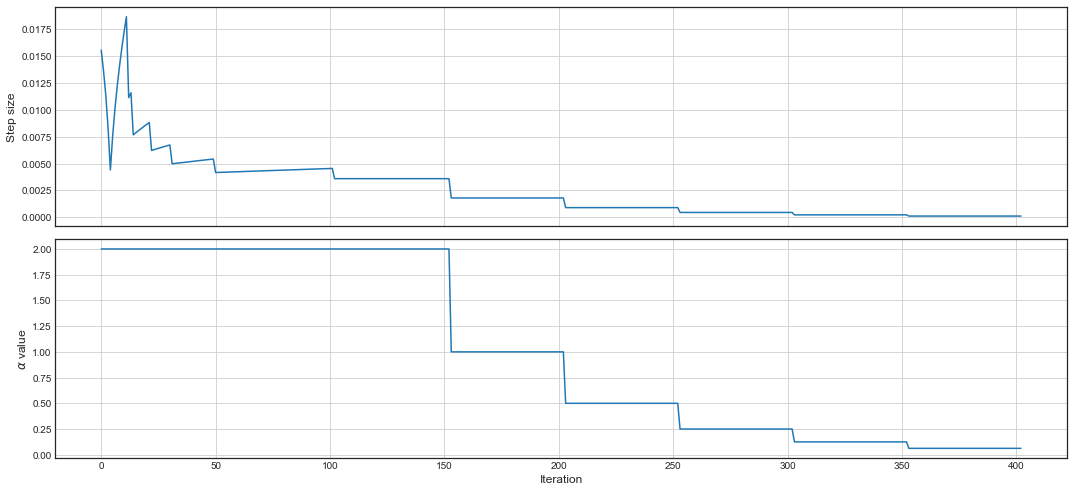

In [257]:
# subgradient step size
def plot_stepsize():
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    
    # subgradient step size
    ax1.plot(Log.d["step_size"])   
    ax1.set_ylabel("Step size")
    ax1.grid(True)
    
    # subgradient alpha param
    ax2.plot(Log.d["alpha"]) 
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel(r"$\alpha$ value")
    ax2.grid(True)
    
    fig.tight_layout()
    plt.show()

plot_stepsize()

In [258]:
# Clean up run data
Log.d.clear()